In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


sns.set_theme(style="darkgrid", palette = 'Set2')

As we did the data analysis in the first part of the problem, here we will focus on implementing a simple anti-fraud concept.

Although we don't have a very large base, we will continue with the machine learning application for fraud detection and a final implementation.

In [2]:
# Read data
dados = pd.read_csv('transactional-sample.csv')
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_id      3199 non-null   int64  
 1   merchant_id         3199 non-null   int64  
 2   user_id             3199 non-null   int64  
 3   card_number         3199 non-null   object 
 4   transaction_date    3199 non-null   object 
 5   transaction_amount  3199 non-null   float64
 6   device_id           2369 non-null   float64
 7   has_cbk             3199 non-null   bool   
dtypes: bool(1), float64(2), int64(3), object(2)
memory usage: 178.2+ KB


As observed in the data analysis, the device_id column did not show much relevance and since more than 25% of the data is missing, I decided to exclude it, rather than eliminating the lines where the values are missing.

In [3]:
dados.drop(columns = 'device_id', inplace = True)
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_id      3199 non-null   int64  
 1   merchant_id         3199 non-null   int64  
 2   user_id             3199 non-null   int64  
 3   card_number         3199 non-null   object 
 4   transaction_date    3199 non-null   object 
 5   transaction_amount  3199 non-null   float64
 6   has_cbk             3199 non-null   bool   
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 153.2+ KB


In [4]:

# Adjusting the date issue and breaking it down to better use the information
dados['transaction_date'] = pd.to_datetime(dados['transaction_date'])
dados['dia'] = dados['transaction_date'].dt.day
dados['mês'] = dados['transaction_date'].dt.month
dados['dia_semana'] = dados['transaction_date'].dt.dayofweek
dados['horario'] = dados['transaction_date'].dt.time
dados['horario'] = dados['transaction_date'].dt.hour * 3600 + dados['transaction_date'].dt.minute * 60 + dados['transaction_date'].dt.second
dados.drop(columns = 'transaction_date', inplace = True)

# Transforming True = 1 and False = 0
dados['has_cbk'] = dados['has_cbk'].astype(int)

In [5]:
dados.head()

,transaction_id,merchant_id,user_id,card_number,transaction_amount,has_cbk,dia,mês,dia_semana,horario
0,21320398,29744,97051,434505******9116,374.56,0,1,12,6,83792
1,21320399,92895,2708,444456******4210,734.87,1,1,12,6,81937
2,21320400,47759,14777,425850******7024,760.36,0,1,12,6,80563
3,21320401,68657,69758,464296******3991,2556.13,1,1,12,6,79159
4,21320402,54075,64367,650487******6116,55.36,0,1,12,6,77453


In [6]:
#T o avoid problems with encoding methods, we will need to remove the * from it and use the first 6 digits along with the last 4
dados['card_number'] = dados['card_number'].str.replace('*', '')
dados['card_number'] = pd.to_numeric(dados['card_number'])

C:\Users\andre\AppData\Local\Temp\ipykernel_12676\2756916295.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dados['card_number'] = dados['card_number'].str.replace('*', '')


Usually in datasets of problems related to fraud detection, we have a significant unbalance of the target variables, a situation that is not so significant in this one, because of that we will not work with any form of oversampling or undersampling

In [7]:
# Splitting the dataframe
X = dados.drop(columns = 'has_cbk')
y = dados[['has_cbk']]


In [8]:
# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import svm
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

# Metrics
from sklearn.metrics import recall_score, f1_score, make_scorer, confusion_matrix, accuracy_score


In [9]:
# Split train test
SEED = 123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state = SEED)

In [10]:

# Preparing columns
numeric_transformer = Pipeline(steps = [
      ('scaler', MinMaxScaler())
])

colunas_numericas = X.select_dtypes(include = np.number).columns

preprocessor = ColumnTransformer(
   transformers = [('numeric', numeric_transformer, colunas_numericas)]
   ) 

# Structuring pipeline with multiple projects


pipe_lr = Pipeline([('preprocessor', preprocessor),
                    ('LR', LogisticRegression(random_state = SEED))])
pipe_dt = Pipeline([('preprocessor', preprocessor),
                    ('DT',DecisionTreeClassifier(random_state = SEED))])
pipe_rf = Pipeline([('preprocessor', preprocessor),
                    ('RF',RandomForestClassifier(random_state = SEED))])
pipe_svm = Pipeline([('preprocessor', preprocessor),
                     ('SVM', svm.SVC(random_state = SEED))])
pipe_xgb = Pipeline([('preprocessor', preprocessor),
                     ('XGB', XGBClassifier(random_state = SEED))])
pipe_lgb = Pipeline([('preprocessor', preprocessor),
                     ('LGB', lgb.LGBMClassifier(random_state = SEED))])
pipe_gb = Pipeline([('preprocessor', preprocessor),
                    ('GB', GradientBoostingClassifier(random_state=SEED))])
pipe_mlp = Pipeline([('preprocessor', preprocessor),
                     ('MLP', MLPClassifier(random_state=SEED))])
pipe_nb = Pipeline([('preprocessor', preprocessor),
                    ('NB', GaussianNB())])

# Models fit
pipelines = [pipe_lr, pipe_dt, pipe_rf, pipe_svm, pipe_xgb, pipe_lgb, pipe_gb, pipe_mlp, pipe_nb]
for pipe in pipelines:
  pipe.fit(X_train, y_train)



grid_dict = {0: 'Logistic Regression', 1: 'Decision Trees', 
             2: 'Random Forest', 3: 'Support Vector Machines',
             4: 'XGBoost', 5: 'LightGBM', 6 : 'GradientBoostingClassifier',
              7 :  'MLPClassifier', 8 : 'GaussianNB'}

# Evaluating the metrics
for i, model in enumerate(pipelines):
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print('{} - Recall: {:.4f} - Accuracy : {} - F1-Score: {:.4f}'.format(grid_dict[i], recall, model.score(X_test,y_test), f1))


c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_

Logistic Regression - Recall: 0.0816 - Accuracy : 0.8825 - F1-Score: 0.1455
Decision Trees - Recall: 0.6020 - Accuracy : 0.89125 - F1-Score: 0.5756
Random Forest - Recall: 0.4490 - Accuracy : 0.91375 - F1-Score: 0.5605
Support Vector Machines - Recall: 0.0102 - Accuracy : 0.87875 - F1-Score: 0.0202
XGBoost - Recall: 0.5918 - Accuracy : 0.92625 - F1-Score: 0.6629
LightGBM - Recall: 0.5714 - Accuracy : 0.9275 - F1-Score: 0.6588
GradientBoostingClassifier - Recall: 0.3469 - Accuracy : 0.9075 - F1-Score: 0.4789
MLPClassifier - Recall: 0.1735 - Accuracy : 0.88875 - F1-Score: 0.2764
GaussianNB - Recall: 0.2959 - Accuracy : 0.83625 - F1-Score: 0.3069


Generally, in the context of fraud detection, recall and F1-Score are more relevant metrics, as they prioritize the correct identification of fraudulent transactions and the minimization of false negatives.
Let's take a closer look at XGBOOST, which was the algorithm that performed best

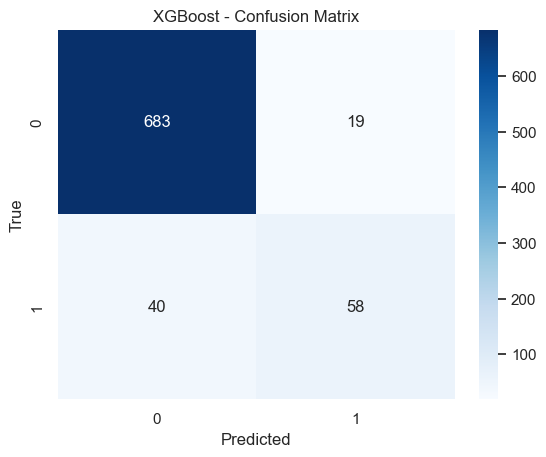

XGBoost - Recall: 0.5918 - Accuracy : 0.92625 - F1-Score: 0.6629


In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

pipelines = [pipe_xgb]

grid_dict = {0:'XGBoost'}

for i, model in enumerate(pipelines):
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot
    plt.figure()
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.title('{} - Confusion Matrix'.format(grid_dict[i]))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
   
    # Print the evaluation metrics
    print('{} - Recall: {:.4f} - Accuracy : {} - F1-Score: {:.4f}'.format(grid_dict[i], recall, model.score(X_test,y_test), f1))



XGBoost - Recall: 0.5918 - Accuracy : 0.92625 - F1-Score: 0.6629

### Tuning Hyperparameters

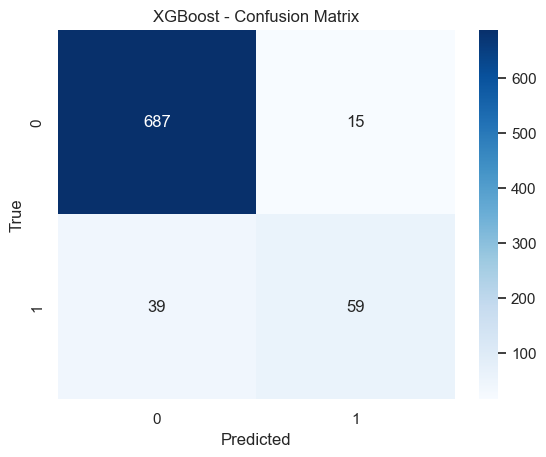

XGBoost - Recall: 0.6020 - Accuracy : 0.9325 - F1-Score: 0.6860


In [16]:
from scipy.stats import uniform, randint

# Grid of hyperparameters
xgb_param_grid = [{'XGB__learning_rate': uniform(0.01, 0.5),
              'XGB__max_depth': randint(3, 15),
              'XGB__n_estimators': randint(100, 1000),
              'XGB__gamma': uniform(0, 1),
              'XGB__min_child_weight': randint(1, 10),
              'XGB__subsample': uniform(0.5, 0.5),
              'XGB__colsample_bytree': uniform(0.5, 0.5),
              'XGB__reg_alpha': uniform(0, 1),
              'XGB__reg_lambda': uniform(0, 1)}]



xgb_param_grid = {
    'XGB__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'XGB__max_depth': [3, 5, 7, 9, 11, 13],
    'XGB__n_estimators': [100, 200, 300, 400, 500],
    'XGB__gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'XGB__min_child_weight': [1, 3, 5, 7, 9],
    'XGB__subsample': [0.6, 0.7, 0.8, 0.9],
    'XGB__colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'XGB__reg_alpha': [0, 0.1, 0.5, 1],
    'XGB__reg_lambda': [0, 0.1, 0.5, 1]
}



# RandomizedSearchCV setup
xgb_grid_search = RandomizedSearchCV(estimator=pipe_xgb,
        param_distributions=xgb_param_grid,
        scoring = make_scorer(accuracy_score),
        cv = 5)

# Model fit
grids = [xgb_grid_search]
for pipe in grids:
    pipe.fit(X_train,y_train)

pipelines = [xgb_grid_search]
grid_dict = {0:'XGBoost'}

recall = 0


# Evaluating the metrics
for i, model in enumerate(pipelines):
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plota
    plt.figure()
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.title('{} - Confusion Matrix'.format(grid_dict[i]))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Imprime as métricas de avaliação
    print('{} - Recall: {:.4f} - Accuracy : {} - F1-Score: {:.4f}'.format(grid_dict[i], recall, model.score(X_test,y_test), f1))
    


hyper: XGBoost - Recall: 0.6020 - Accuracy : 0.9325 - F1-Score: 0.6860

xgb_grid_search.best_params_

{'XGB__subsample': 0.8,
 'XGB__reg_lambda': 0.1,
 'XGB__reg_alpha': 0,
 'XGB__n_estimators': 400,
 'XGB__min_child_weight': 3,
 'XGB__max_depth': 7,
 'XGB__learning_rate': 0.1,
 'XGB__gamma': 0,
 'XGB__colsample_bytree': 0.7}

In [18]:
confusion_matrix(y_test, y_pred)

array([[687,  15],
       [ 39,  59]], dtype=int64)

## Saving model

In [13]:
import pickle   

#with open('modelo_treinado.pkl', 'wb') as file:
#    pickle.dump(pipe_xgb, file)